# Import Libraries

In [5]:
import pandas as pd
import numpy as np
from numpy.random import seed # for reproducible results
seed(1)
import matplotlib.pyplot as plt

from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

import statsmodels.formula.api as smf

# Helper functions

In [58]:
def oos_r2_score(y_true, y_pred, y_train):

    mse = mean_squared_error(y_true, y_pred)
    mse_trainmean = mean_squared_error(y_true, np.full_like(y_true, np.mean(y_train)))
    r2 = 1 - mse/mse_trainmean

    return r2

def Strategy(y_test, y_pred):
    return(np.array([1 if v > 0 else -1 for v in y_pred]*y_test.values.reshape(-1,)))

def Profitability(y_test,y_pred):
    return(np.mean(Strategy(y_test, y_pred))*252)

def PlotCumulativeReturns(y_test, y_pred):
    plt.clf()
    plt.plot(y_test.index,(y_test.values + 1).cumprod() - 1,label='Buy and Hold')
    plt.plot(y_test.index,(Strategy(y_test, y_pred) + 1).cumprod() - 1,label='Strategy')
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.show()
    
def compute_alpha(y_test, y_pred):
    
    ols_data = pd.DataFrame({'buy_hold_ret': y_test.values.reshape(-1,), 'strat_ret':Strategy(y_test, y_pred).reshape(-1,)})
    
    ols = smf.ols('strat_ret ~ buy_hold_ret', ols_data).fit()
    
    ols_params = ols.params
    ols_t_vals = ols.tvalues
    
    results = {'alpha': ols_params[0]*252, 't_alpha': ols_t_vals[0], 'beta': ols_params[1], 't_beta': ols_t_vals[1], 'R2': ols.rsquared}
    
    return results
    
def evaluate_estimator(y_test, y_pred):
    
    print(f'Buy and hold profitability:{np.mean(y_test)*252}')
    print(f'Strategy profitability:{Profitability(y_test, y_pred)}; {compute_alpha(y_test,y_pred)}')
    
    PlotCumulativeReturns(y_test, y_pred)
    
    return None

# Prepare Data

In [7]:
X = pd.read_csv('forecast_sp500_features_bahare.csv')
y = pd.read_csv('sp500_returns_daily.csv')

In [8]:
y = y.rename(columns={'caldt':'date'})

In [9]:
X = X.set_index('date')
y = y.set_index('date')

In [10]:
y.index = pd.to_datetime(y.index)
X.index = pd.to_datetime(X.index)

In [11]:
X = X.loc['1963-01-01':]
y = y.loc['1963-01-01':]
X = X.dropna(axis=1)
y = y.shift(-1).dropna()

In [18]:
train_start ='1963-01-02'
train_cutoff = '1999-12-31'
X_train = X.loc[train_start:train_cutoff]
y_train = y.loc[train_start:train_cutoff]


test_start = datetime.strptime(train_cutoff, '%Y-%m-%d') + relativedelta(days=1)
test_end = '2021-12-31'

X_test = X.loc[test_start:test_end]
y_test = y.loc[test_start:test_end]

In [19]:
X_test.shape

(5536, 119)

In [20]:
y_test.shape

(5536, 1)

In [57]:
y_test

,sprtrn
date,
2000-01-03,-0.038345
2000-01-04,0.001922
2000-01-05,0.000956
2000-01-06,0.027090
2000-01-07,0.011190
...,...
2021-12-27,-0.001010
2021-12-28,0.001402
2021-12-29,-0.002990


# Linear regression

y  = b0 + b1x1 + ... + bpxp + e 
assume e is normally distributed with constant variance and we call homoskedaticity.

yhat = b0hat + b1hatx1 + ... + bphatxp

sum( (yhat - y)^2 )

b_vec = (X'X)^(-1)X'y

b1hat = Cov(x,y) / Var (x) 
b0hat = ybar - b1hat*xbar



In [25]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X_train, y_train)

In [26]:
lr.coef_[0,:10]

array([-4.20580199e-04,  1.46051199e-03,  1.91605383e-04, -2.60650691e-04,
       -1.03610596e-03, -2.26189918e-04,  7.13521205e-04, -7.40060353e-05,
        3.92241427e-05, -2.19006878e-04])

In [27]:
lr_pred = lr.predict(X_test)

In [38]:
lr_pred.shape

(5536, 1)

In [39]:
y_test.shape

(5536, 1)

C:\Users\Robpr\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Buy and hold profitability:sprtrn    0.073611
dtype: float64
Strategy profitability:-0.040366612716763006; {'alpha': -0.04943853759729704, 't_alpha': -1.1885749223710504, 'beta': 0.12324060225518418, 't_beta': 9.236571046288283, 'R2': 0.015182323140888854}


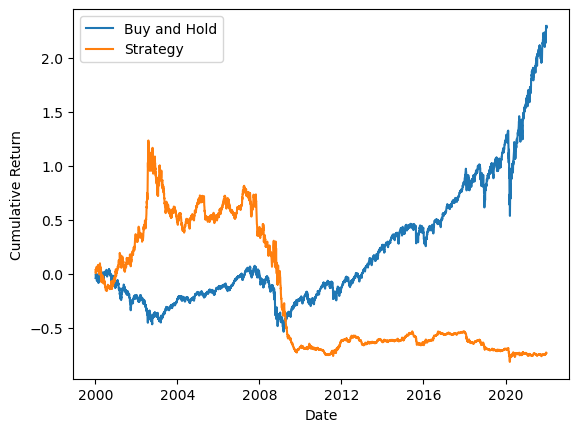

In [59]:
evaluate_estimator(y_test, lr_pred)

# Ridge Regression

In [60]:
from sklearn.linear_model import Ridge

$MSE = 1/n * \sum_{i=1}^n (y_i - \hat{y}_i)^2$ 

Ridge loss:  $MSE + \alpha * \sum_{j=1}^p \hat{\beta}_j^2, \qquad \alpha \in [0,\infty)$ 

In [61]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [63]:
ridge_grid ={
    'alpha': [10**5, 10**4, 10**3, 10**2] 
}

tscv = TimeSeriesSplit()

ridge = Ridge(random_state=1)

ridge_fit = GridSearchCV(ridge, ridge_grid, scoring='neg_root_mean_squared_error', cv=tscv, refit=True).fit(X_train, y_train)

print(ridge_fit.best_params_,
     ridge_fit.best_score_)

{'alpha': 1000} -0.00930472642233235


C:\Users\Robpr\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Buy and hold profitability:sprtrn    0.073611
dtype: float64
Strategy profitability:-0.03925528179190751; {'alpha': -0.04489094503731652, 't_alpha': -1.0741666107386665, 'beta': 0.07655955506883941, 't_beta': 5.710949466853958, 'R2': 0.0058590263817706045}


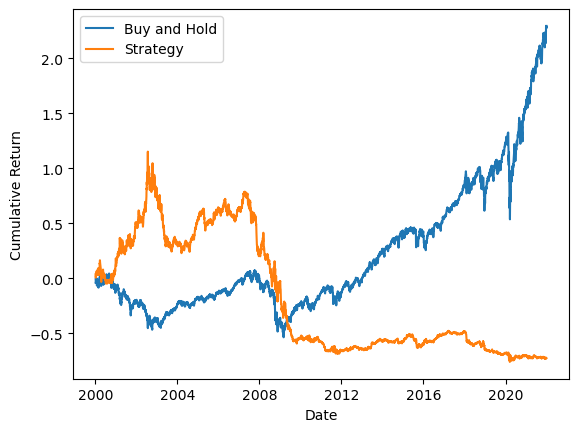

In [64]:
ridge_pred = ridge_fit.predict(X_test)
evaluate_estimator(y_test, ridge_pred)

# LASSO

Ridge loss:  $MSE + \alpha * \sum_{j=1}^p |\hat{\beta}_j|, \qquad \alpha \in [0,\infty)$ 

C:\Users\Robpr\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Buy and hold profitability:sprtrn    0.073611
dtype: float64
Strategy profitability:0.07361149421965317; {'alpha': 1.0245710529988017e-16, 't_alpha': 3.663669725932564, 'beta': 0.9999999999999993, 't_beta': 1.1147314398281202e+17, 'R2': 1.0}


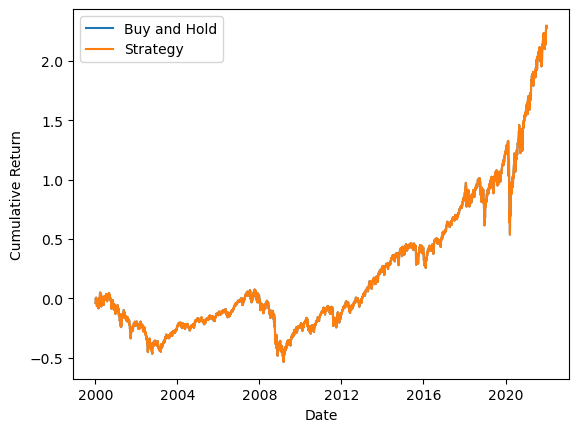

In [66]:
from sklearn.linear_model import Lasso

lasso = Lasso(random_state=1)

lasso_grid = {
    'alpha': [10**3, 10**2, 10*1, 1, 0.01]
}

lasso_fit = GridSearchCV(lasso, lasso_grid, scoring='neg_root_mean_squared_error', refit=True, cv=tscv, n_jobs=-1).fit(X_train, y_train)

lasso_pred = lasso_fit.predict(X_test)

evaluate_estimator(y_test, lasso_pred)

In [67]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

C:\Users\Robpr\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Buy and hold profitability:sprtrn    0.073611
dtype: float64
Strategy profitability:-0.08805861416184972; {'alpha': -0.09664221295122274, 't_alpha': -2.3222887034934585, 'beta': 0.11660677290098362, 't_beta': 8.73512523795504, 'R2': 0.01360040997914913}


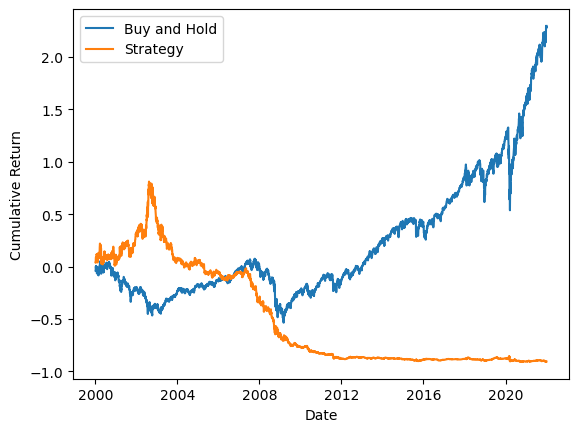

In [69]:
pcr_grid = {
    'PCA__n_components': list(range(1,21))
}

pipe = Pipeline(
    [
        ('PCA', PCA(random_state=1)),
        ('OLS', LinearRegression())
    ]
)

pcr_fit = GridSearchCV(pipe, pcr_grid, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1).fit(X_train, y_train)

pcr_pred = pcr_fit.predict(X_test)

evaluate_estimator(y_test, pcr_pred)